# ANALYSIS OF REAL DATA (SRON)

From real MnKa1, MnKa2, MnKb it creates a library of optimal filters and reconstruct (and calibrate) data calculating FWHM of lines

**Energy units are eV**

Imports and definitions

PREPROCESSING

00) Creation of Kas library

        i) Transform h5 files to FITS (using PHASE info) 
        ii) Populate PH_ID column with row (record) number
        iii) Select records with Ka1 and Ka2 lines (by limiting the Pulse height)
        iv) Create a library with this new file with Kas lines

0) Creation of Ka1 library

    i) Reconstruct real data with initial (Kas) library
    
    ii) Select only Ka1 pulses not in multiple-pulse records 
    
        ii.0 Find/identify multiple-pulse records
        ii.1 Read data from HR Kas evt file to identify Ka1 and Ka2
        ii.2 Fit a double Gaussian to select Ka1 pulses
        ii.3 Select PH_ID of (non)Ka1 pulses
        ii.4 Extract Ka1 pulses to build the new library
        
    iii) Build the new library of Ka1 pulses

PROCESSING

00) Select only data pulses HR (8192)
    
    - Reconstruct pulses with largest length possible (BYGRADE)
    - Selct non-truly HR events to be avoided afterwards
    - Extract PH_ID of those photons in non-HR events and select HR records

0) Reconstruct HR pulses with selected record length and library Ka1

1. Read reconstructed events

2. Calibrate data fitting 2 Gaussians (Kas) + 1 Gaussian (Kb) - No correctio yet - OPTIONAL

        2.1 Fit 2 gaussians to Kas and 1 gaussian to Kb
        2.2 Create gain scale
        2.3 Calibrate energies (eV)
        2.4 Get FWHM of Kas & Kb lines fitting Voigt profiles

3. Jitter correction

    3.1 Plot recon PH vs PHASE (distance between trigger and parabola fit=PHI+LAGS) & Fit a polynomial
    
    3.2 Fit gaussians, create new Gain scale and re-calibrate energies (OPTIONAL)
    
    3.3 Fit histogram of jitter-corrected energies (OPTIONAL)
    
4. baseline drift correction

    4.1 Plot jiterr_recon PH vs Baseline & Fit polynomial
    
    4.2 Fit gaussians, create new Gain scale and re-calibrate energies
    
5. Fit histogram of baseline-jitter-corrected energies

    - Test different number of bins and see how residuals respond
    - Use the range of number of bins where residuals are quite estable and use them to get different FWHM; then tak emedian value
    
6. Plot FWHM comparison of different reconstruction methods/lengths

7. Recalibrate energies:
      - get new gain scale with fitted line centres
      - recalibrate energies
      - fit again to get FWHM more precisely
        

## Imports and definitions

In [56]:
from subprocess import check_call, STDOUT
import os
import numpy.polynomial.polynomial as poly
from numpy.polynomial import Polynomial as P
import tempfile
from datetime import datetime
import shutil, shlex
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas
from RxLines import RxLines
from fit2GaussAndRatio import fit2GaussAndRatio
from getMaximaDensity import getMaximaDensity
from fit3gauss2hist import fit3gauss2hist
from gainScaleFit import gainScaleLinearFit, gainScalePolyFit
from fitVoigt2hist import fitVoigt2hist
from jitterCorr import jitterCorr
from hdf5_to_fits import hdf5_to_fits

cwd = os.getcwd()
tmpDir = tempfile.mkdtemp()
os.environ["PFILES"] = tmpDir + ":" + os.environ["PFILES"]
os.environ["HEADASNOQUERY"] = ""
os.environ["HEADASPROMPT"] = "/dev/null/"

In [2]:
# data files
fileNum = "2" # use this because there are 2 data files
noiseNum = "1" # and 3 noise files
resDir = "file" + str(fileNum) + "noise" + str(noiseNum)
if not os.path.exists(resDir):
    os.makedirs(resDir)
ratio = 5 # ratio Ka1_gaussProb/Ka2_gaussProb
file0ph = "file" + fileNum + "ph.fits"   # initial data file with all records
fileph  = "file" + fileNum + "ph_phid.fits" # initial data file with all records and PH_ID column populated
filephHR  = "file" + fileNum + "ph_phid_HR.fits" # initial data file with all records and PH_ID column populated and High Res events
fileph_Kas = "file" + fileNum + "ph_phid_Kas.fits" # data file with only those records with Kas lines
noiseph = "noise" + noiseNum + "ph.fits"
noisefile = "noise" + noiseNum + "ph_8192_noisespec_1sigma.fits"

In [3]:
PHmin = 159000 # ADC units to limit Kas lines
PHmax = 161000 
# Calibration lines CALDB20161122: relative amplitudes of Lorentzians in table = amplitudes of fitted Voigt 
# MnKa
ilabels = ["Ka11","Ka12", "Ka13", "Ka14", "Ka15", "Ka16",  "Ka21", "Ka22"]
energies_eV = np.array([5898.882, 5897.898, 5894.864, 5896.566, 5899.444, 5902.712, 5887.772, 5886.528], dtype=np.float64)
fwhms_eV = np.array([1.7145, 2.0442, 4.4985, 2.6616, 0.97669, 1.5528, 2.3604, 4.2168], dtype=np.float64)
rel_amplitudes = np.array([0.784, 0.263, 0.067, 0.095, 0.071, 0.011, 0.369, 0.1], dtype=np.float64)
MnKas = RxLines(complabel="MnKa", ilabels=ilabels, energies_eV=energies_eV, fwhms_eV=fwhms_eV, rel_amplitudes=rel_amplitudes)
MnKas_cmass = 5894.40 # eV
Ka2_cmass = 5887.77 # eV 
Ka1_cmass = 5897.97 # eV 
#Ka2_cmass = 5887.65 # eV wikipedia nominal
#Ka1_cmass = 5898.75 # eV wikipedia nominal
#Ka2_cmass = 5887.772 # eV most intense
#Ka1_cmass = 5898.882 # eV most intense

# define range to set histogram interval
min_Ka = 5870 # histogram min energy for MnKa
max_Ka = 5920 # histogram max energy for MnKa
min_Kb = 6420 # histogram min energy for MnKb
max_Kb = 6550 # histogram max energy for MnKb
ilabels = ['Kb1', 'Kb2', 'Kb3', 'Kb4', 'Kb5']
energies_eV = np.array([6490.89, 6486.31, 6477.73, 6490.06, 6488.83], dtype=np.float64)
fwhms_eV = np.array([1.83, 9.4, 13.22, 1.81, 2.81,], dtype=np.float64)
rel_amplitudes = np.array([0.608, 0.109, 0.077, 0.397, 0.176], dtype=np.float64)
MnKb = RxLines(complabel="MnKb", ilabels=ilabels, energies_eV=energies_eV, fwhms_eV=fwhms_eV, rel_amplitudes=rel_amplitudes)
#MnKb_cmass = 6486.38 # eV
MnKb_cmass = 6490.45 # eV "nominal"
#MnKb_cmass = 6490.89 # eV "most intense"
deg = 2 # degree of polynomial for gainscale fit 1=linear; >1: polynomial
lines = (Ka2_cmass, Ka1_cmass, MnKb_cmass)

In [4]:
# select SIRENA parameters for library Kas creation and reconstruction of data files
plen = 8192
oflen = 8192
liblen = 8192 # length of maximum optimal filter for library creation
preBuffer = 75
pBstr = ""
if preBuffer > 0:
    pBstr = "_pB" + str(preBuffer)
method = "OPTFILT"
F0orB0 = "F0"
nS = 5
sU = 3
sD = 4
KaseV = 5895 # eV reference energy: 8.2%*5.88765(Ka2)+16.2%*5.89875(Ka1) for initial Kas library
libKas = resDir + "/" + "library_Kas_" + str(plen) + ".fits"

In [5]:
# reconstructed files
evtKas_libKas = resDir + "/" + "evt_file" + fileNum + "phKas_lib" + noiseNum + "file" + fileNum + "phKas_" + "pL" + str(plen) + "_" + method + str(oflen) + ".fits"
evtKas_libKas_HR = resDir + "/" + "evt_file" + fileNum + "phKas_lib" + noiseNum + "file" + fileNum + "phKas_" + "pL" + str(plen) + "_" + method + str(oflen) + "_HR.fits"
evt_libKa1 = resDir + "/" + "evt_file" + fileNum + "ph_lib" + noiseNum + "file" + fileNum + "phKa1_" + "pL" + str(plen) + "_" + method + str(oflen) + pBstr + ".fits"
evt_libKa1_HR = resDir + "/" + "evt_file" + fileNum + "ph_lib" + noiseNum + "file" + fileNum + "phKa1_" + "pL" + str(plen) + "_" + method + str(oflen) + pBstr + "_HR.fits"
evt_libKa1_abs = resDir + "/" + "evtabs_file" + fileNum + "ph_lib" + noiseNum + "file" + fileNum + "phKa1_" + "pL" + str(plen) + "_" + method + str(oflen) + ".fits"
evt_libKa1_abs_HR = resDir + "/" + "evtabs_file" + fileNum + "ph_lib" + noiseNum + "file" + fileNum + "phKa1_" + "pL" + str(plen) + "_" + method + str(oflen) + "_HR.fits"

In [6]:
# library Ka1 creation
fileph_Ka1 = resDir + "/" + "file_Ka1.fits" # data file with only those single records with Ka1 lines
libKa1 = resDir + "/" + "library_Ka1_ratio" + str(ratio) + "_8192" +  pBstr + ".fits"

## PREPROCESSING

## 00) Creation of Kas library

### i) Transform h5 files to FITS (using PHASE)

In [7]:
%%script false --no-raise-error

# get data file
hdf5_to_fits(input_hdf5_file="file" + fileNum + ".h5", output_fits_file=file0ph, model_fits_file="model.fits", use_phase = True,
                 channel_number = 0, freq_number = 6, sampling_rate=156250 )
# get noise file
hdf5_to_fits(input_hdf5_file="noise" + noiseNum + ".h5", output_fits_file=noiseph, model_fits_file="model.fits", use_phase = True,
                 channel_number = 0, freq_number = 6, sampling_rate=156250 )


### ii) Populate PH_ID column with row (record) number
The idea is to be able to later identify which records contains pulses with the appropriate energy to build the library

In [8]:
%%script false --no-raise-error

comm =  ("fcalc infile=" + file0ph + "+8 outfile=" + fileph + " clname=PH_ID expr='#ROW'")
print(comm)
try:
    print("Populating PH_ID column")
    #print(comm)
    args = shlex.split(comm)
    check_call(args, stderr=STDOUT)
except:
    print("Error populating PH_ID column with command:\n", comm)
    shutil.rmtree(tmpDir)
    raise

### iii) Select records with just Ka1 and Ka2 lines (by limiting the Pulse height)

In [9]:
%%script false --no-raise-error

comm = ("fselect  infile=" + fileph + "+8 outfile=" + fileph_Kas + " expr='max(ADC)>" + str(PHmin) + " && max(ADC)<" + str(PHmax) +"'")
try:
    print("Selecting Kas by Pulse Height")
    #print(comm)
    args = shlex.split(comm)
    check_call(args, stderr=STDOUT)
except:
    print("Error Selecting Kas by Pulse Height with command:\n", comm)
    shutil.rmtree(tmpDir)
    raise

### iv) Create a library with this new file with Kas lines

In [10]:
%%script false --no-raise-error
# calculate noise spectrum
comm = ("gennoisespec --inFile=" + noiseph + " --outFile=" + noisefile + " --intervalMinSamples=" + str(liblen) +
        " --nintervals=1999 --pulse_length= -clobber=yes")
try:
    print("Getting noise spectrum")
    print(comm)
    args = shlex.split(comm)
    check_call(args, stderr=STDOUT)
except:
    print("Error building noise spectrum:\n", comm)
    shutil.rmtree(tmpDir)
    raise

In [11]:
%%script false --no-raise-error

# reconstruct data file
tmpFile = resDir + "/" + "pp" + str(int(datetime.timestamp(datetime.now()))) + ".fits"
comm = ("tesreconstruction Recordfile=" + fileph_Kas + " TesEventFile=" + tmpFile + " PulseLength=" + str(plen) + 
        " LibraryFile=" + libKas + " samplesUp=" + str(sU) + " nSgms=" + str(nS) + " samplesDown=" + str(sD) + 
        " opmode=0 FilterMethod=" + F0orB0 + " clobber=yes EnergyMethod=" + method + 
        " OFStrategy=BYGRADE OFLength=" + str(liblen) + " NoiseFile=" + noisefile +
        " XMLFile=${SIXTE}/share/sixte/instruments/athena-xifu//xifu_detector_lpa_75um_AR0.5_pixoffset_mux40_pitch275um.xml" +
        " monoenergy=" + str(KaseV) + " preBuffer=" + str(preBuffer))
try:
    print("Building initial library (Kas)")
    print(comm)
    args = shlex.split(comm)
    check_call(args, stderr=STDOUT)
except:
    print("Error Building initial library (Kas) with command:\n", comm)
    shutil.rmtree(tmpDir)
    raise
os.remove(tmpFile)
print("##########################################")
print("Finished creation of Library of Kas events")
print("##########################################")

## 0) Creation of Ka1 library

### i) Reconstruct real data with initial (Kas) library

In [12]:
%%script false --no-raise-error
comm = ("tesreconstruction Recordfile=" + fileph_Kas + " TesEventFile=" + evtKas_libKas + " PulseLength=" + str(plen) +
        " LibraryFile=" + libKas + " samplesUp=" + str(sU) + " nSgms=" + str(nS) + " samplesDown=" + str(sD) + " opmode=1 " +
        " clobber=yes EnergyMethod=" + method + " filtEeV=" + str(KaseV) + " OFStrategy=BYGRADE OFLength=" + str(liblen) + 
        " preBuffer=" + str(preBuffer) +
        " XMLFile=${SIXTE}/share/sixte/instruments/athena-xifu//xifu_detector_lpa_75um_AR0.5_pixoffset_mux40_pitch275um.xml")

try:
    print("Reconstructing real data w/ initial library (Kas)")
    print(comm)
    args = shlex.split(comm)
    check_call(args, stderr=STDOUT)
except:
    print("Error Reconstructing real data w/ initial library (Kas) with command:\n", comm)
    shutil.rmtree(tmpDir)
    raise

# Select only HR events
comm = ("fselect  infile=" + evtKas_libKas + " outfile=" + evtKas_libKas_HR + " expr='GRADE1 == " + str(liblen) + 
       " && GRADE2 > 500'")
try:
    print("Selecting HR Kas evts")
    print(comm)
    args = shlex.split(comm)
    check_call(args, stderr=STDOUT)
except:
    print("Error Selecting HR Kas evts with command:\n", comm)
    shutil.rmtree(tmpDir)
    raise

### ii) Select only Ka1 pulses not in multiple-pulse records 

#### ii.0) Find/identify multiple-pulse records so as not to use them for future Ka1 library

In [13]:
%%script false --no-raise-error
# dump records info
colname = "'SIGNAL, PH_ID, GRADE1, GRADE2'" 
comm = ("fdump wrap=yes infile=" + evtKas_libKas + "+1 columns=" + colname + " rows='-' prhead=no " +
        "showcol=yes showunit=no showrow=no outfile=pulse.txt clobber=yes")
try:
    print("FDUMPing evt file")
    #print(comm)
    args = shlex.split(comm)
    check_call(args, stderr=STDOUT)
except:
    print("Error FDUMPing evt file with command:\n", comm)
    shutil.rmtree(tmpDir)
    raise
    
# find single records
dataKas = pandas.read_csv("pulse.txt", skiprows=0, sep="\s+")
n_ocurr = dataKas.PH_ID.value_counts() # number of ocurrences of each PH_ID
dataKas_single_PH_ID = list()
for key in sorted(n_ocurr.keys()):
    if n_ocurr[key] == 1:
        #print("Single record for PH_ID=", key)
        dataKas_single_PH_ID.append(key)

os.remove("pulse.txt")
#print("Single records in ",fileph_Kas, "=", dataKas_single_PH_ID)
print("Number of Kas records in",fileph_Kas, "=", len(dataKas))
print("Number of Single Kas records in",fileph_Kas, "=", len(dataKas_single_PH_ID))

#### ii.1) Read data from HR Kas evt file to identify Ka1 and Ka2

In [14]:
%%script false --no-raise-error

colname = "'SIGNAL, PH_ID, GRADE1, GRADE2'" 
comm = ("fdump wrap=yes infile=" + evtKas_libKas_HR + "+1 columns=" + colname + " rows='-' prhead=no " +
        "showcol=yes showunit=no showrow=no outfile=pulse.txt clobber=yes")
try:
    print("FDUMPing evt file")
    #print(comm)
    args = shlex.split(comm)
    check_call(args, stderr=STDOUT)
except:
    print("Error FDUMPing evt file with command:\n", comm)
    shutil.rmtree(tmpDir)
    raise
dataKas_HR = pandas.read_csv("pulse.txt", skiprows=0,sep="\s+")
os.remove("pulse.txt")
print("Number of HR Kas pulses in",fileph_Kas, "=", len(dataKas_HR))


#### ii.2) Fit a double Gaussian to select Kas pulses

Ka1 pulses will be those where the probability Ka1/Ka2 >= 'ratio' 

In [15]:
%%script false --no-raise-error

nbinsKas = 100

# select data in Kas range (otherwise there is always a smaller pulse comimg from multiple-pulse rows)
# print(min(dataKas_HR.SIGNAL), max(dataKas_HR.SIGNAL))
dataKas_HR = dataKas_HR[(dataKas_HR.SIGNAL>5.87) & (dataKas_HR.SIGNAL<5.93)]
# print(min(dataKas_HR.SIGNAL), max(dataKas_HR.SIGNAL))

# Get the range where prob(Ka1)/prob(Ka2)>ratio
(PHmin,PHmax) = fit2GaussAndRatio(data=dataKas_HR.SIGNAL, a1=60, a2=140, mean1=5.892, mean2=5.90, 
                                        sig1=0.005, sig2=0.005, nbins1=nbinsKas, ratio=ratio, xlab="Reconstructed PH (a.u.)",
                                        xlim=(5.87,5.93), ylim=(0,150))
print("PHmin=",PHmin, "PHmax=", PHmax)

#### ii.3) Select PH_ID of (non)Ka1 pulses

In [16]:
%%script false --no-raise-error

#select PH_IDs for Ka1 (in [PHmin,PHmax] interval)
dataKa1 = dataKas_HR[(dataKas_HR.SIGNAL >= PHmin) & (dataKas_HR.SIGNAL <= PHmax)]
print("Kas pulses which are Ka1 pulses in PHmin,PHmax interval=", len(dataKa1))

PH_ID_Ka1 = dataKa1.PH_ID.to_list()
PH_ID_Ka1_single = set(PH_ID_Ka1).intersection(dataKas_single_PH_ID) # good Ka1 pulses

#select PH_IDs to exclude Ka1 in single-pulse records
PH_ID_noKa1 = list(set(dataKas.PH_ID.to_list()).difference(PH_ID_Ka1_single))
print("Kas pulses which are not non-Ka1-single pulses:", len(PH_ID_noKa1))

#### ii.4) Extract Ka1 pulses to build a new library

In [17]:
%%script false --no-raise-error

tmpFile = resDir + "/" + "pp" + str(int(datetime.timestamp(datetime.now()))) + ".fits"
nphs = len(PH_ID_noKa1)
# first iteration (requires an initial "'" and input/output files are the original/final)
expr = "'PH_ID != " + str(PH_ID_noKa1[0]) + "'"
comm = ("fselect infile=" + fileph_Kas + "+8 outfile=" + fileph_Ka1 + " clobber=yes expr=" + expr)
try:
    print("Selecting Ka1 pulses")
    print(comm)
    args = shlex.split(comm)
    check_call(args, stderr=STDOUT)
except:
    print("Error Selecting Ka1 pulses with command:\n", comm)
    shutil.rmtree(tmpDir)
    raise
# other non-selections follow: create expressions with 20 selections (ftools breaks if expression is too large)
iph = 1
while iph < nphs:
    expr = "'"
    iiph = 1
    while (iiph < 20 and iph < nphs-1):
        expr = expr + "PH_ID != " + str(PH_ID_noKa1[iph]) + " && "
        iiph += 1
        iph  += 1

    expr = expr + "PH_ID != " + str(PH_ID_noKa1[iph]) + "'"
    iph += 1
    comm = ("fselect infile=" + fileph_Ka1 + "+8 outfile=" + tmpFile + " clobber=yes expr=" + expr)
    try:
        print("Selecting Ka1 pulses")
        print("iph=" + str(iph) + "/" + str(nphs))
        print(comm)
        args = shlex.split(comm)
        check_call(args, stderr=STDOUT)
    except RuntimeError:
        print("Error Selecting Ka1 pulses with command:\n", comm)
        shutil.rmtree(tmpDir)
        raise
    shutil.copy(tmpFile, fileph_Ka1)
    os.remove(tmpFile)

print("Finshed selection of Ka1 events")
# raise SystemExit("Stop after selection of Ka1")

### iii) Build the new library of Ka1 pulses

In [18]:
%%script false --no-raise-error
tmpFile = resDir + "/" + "pp" + str(int(datetime.timestamp(datetime.now()))) + ".fits"
comm = ("tesreconstruction Recordfile=" + fileph_Ka1 + " TesEventFile=" + tmpFile + " PulseLength=" + str(plen) +
        " LibraryFile=" + libKa1 + " samplesUp=" + str(sU) + " nSgms=" + str(nS) + " samplesDown=" + str(sD) +
        " opmode=0" + " FilterMethod=" + F0orB0 + " clobber=yes" + " EnergyMethod=" + method +  " NoiseFile=" + noisefile + 
        " XMLFile=${SIXTE}/share/sixte/instruments/athena-xifu//xifu_detector_lpa_75um_AR0.5_pixoffset_mux40_pitch275um.xml" +
        " OFStrategy=BYGRADE OFLength=" + str(liblen) + " monoenergy=" + str(Ka1_cmass) + " preBuffer=" + str(preBuffer))
try:
    print("Building new library (Ka2)")
    print(comm)
    args = shlex.split(comm)
    check_call(args, stderr=STDOUT)
except:
    print("Error Building initial library (Kas) with command:\n", comm)
    shutil.rmtree(tmpDir)
    raise
os.remove(tmpFile)

# PROCESSING

### 00. Select only data pulses HR (8192) 

so that it can be reconstructed at different record lengths to calculate FWHM

### Reconstruct pulses with largest length possible (BYGRADE)

In [19]:
%%script false --no-raise-error
# reconstruct pulses with largest length possible (BYGRADE)
comm = ("tesreconstruction Recordfile=" + fileph + " TesEventFile=" + evt_libKa1 + " PulseLength=" + str(plen) +
        " LibraryFile=" + libKa1 + " samplesUp=" + str(sU) + " nSgms=" + str(nS) + " samplesDown=" + str(sD) +
        " opmode=1 clobber=yes EnergyMethod=" + method +
        " XMLFile=${SIXTE}/share/sixte/instruments/athena-xifu//xifu_detector_lpa_75um_AR0.5_pixoffset_mux40_pitch275um.xml" +
        " filtEeV=" + str(Ka1_cmass) + " OFStrategy=BYGRADE OFLength=" + str(liblen) + " preBuffer=" + str(preBuffer))
try:
    print("Reconstructing real data w/ library (Ka1)")
    print(comm)
    args = shlex.split(comm)
    check_call(args, stderr=STDOUT)
except:
    print("Error Reconstructing real data w/ initial library (Ka2) with command:\n", comm)
    shutil.rmtree(tmpDir)
    raise         

### Select non-truly HR events to be avoided afterwards

If we selected pulses HR and identify their records as "good" there could be other non-HR pulses in the same record. 
It is best if we identify "bad records" (those with non-HR pulses) and then avoid them for the HR data 

In [20]:
%%script false --no-raise-error
# Select non-truly HR events (GRADE1==8192) to be avoided afterwards
tmp0File = resDir + "/" + "pp0.tmp"
comm = ("fselect  infile=" + evt_libKa1 + " outfile=" + tmp0File + " expr='GRADE1 < 8192 || GRADE2 <=500' clobber=yes")
try:
    print("Selecting non-HR evts")
    print(comm)
    args = shlex.split(comm)
    check_call(args, stderr=STDOUT)
except:
    print("Error Selecting non-HR evts with command:\n", comm)
    shutil.rmtree(tmpDir)
    raise


### Extract PH_ID of those photons in non-HR events and select HR records

In [21]:
%%script false --no-raise-error

# extract PH_ID of those photons in non-HR events. Save them to txt file
txtfile = resDir + "/" + "PH_IDs_file2ph_nonHR.txt"

comm = ("fdump wrap=yes infile=" + tmp0File + "+1 columns=PH_ID rows='-' prhead=no " +
    "showcol=no showunit=no showrow=no outfile=" + txtfile + " clobber=yes")
try:
    print("FDUMPing evt file")
    print(comm)
    args = shlex.split(comm)
    check_call(args, stderr=STDOUT)
except:
    print("Error FDUMPing evt file with command:\n", comm)
    shutil.rmtree(tmpDir)
    raise
os.remove(tmp0File)

# convert PH_IDs file to an expression for fselect 
lines_notseen = list()
with open(txtfile) as txt:
    lines = txt.readlines()
    # remove blank lines
    while (lines[0].lstrip()).rstrip() == "":
        lines.pop(0)
    # rm duplicated lines
    for line in lines:
        if line not in lines_notseen:
            lines_notseen.append(line)
    # get last row
    last = lines_notseen[-1]
    iline = 0
    for line in lines_notseen:
        #print(line)
        if iline == 0:
            expr = "'PH_ID!=" + (line.lstrip()).rstrip() + "'"
            comm = ("fselect  infile=" + fileph  + "+8 outfile=" + filephHR + " expr=" + expr  + " clobber=yes")
            expr = "'"
            iline += 1
        elif iline < 20:  # create expression with 20 values for fselect (it breaks if too large)
            if line is last:
                expr += "PH_ID!=" + (line.lstrip()).rstrip() + "'"
                comm = ("fselect  infile=pp.fits+8 outfile=" + filephHR + " expr=" + expr  + " clobber=yes")
            else:
                expr += "PH_ID!=" + (line.lstrip()).rstrip() + " && "
                iline += 1
                continue
        else: # iline == 20:
            expr += "PH_ID!=" + (line.lstrip()).rstrip() + "'"
            comm = ("fselect  infile=pp.fits+8 outfile=" + filephHR + " expr=" + expr  + " clobber=yes")
            iline = 1
            expr = "'"

        try:
            print("Removing non-HR records")
            print(comm)
            args = shlex.split(comm)
            check_call(args, stderr=STDOUT)
        except:
            print("Error Selecting non-HR records with command:\n", comm)
            shutil.rmtree(tmpDir)
            raise
        if os.path.isfile("pp.fits"):
            os.remove("pp.fits")
        if line is not last:
            shutil.copy(filephHR, "pp.fits")
                
os.remove(txtfile)

## 0. Reconstruct HR data file with selected record length 
(try different record lengths to get variation of FWHM)

In [22]:
%%script false --no-raise-error
# reconstruct HR pulses according to input pulseLength and OFlength
comm = ("tesreconstruction Recordfile=" + filephHR + " TesEventFile=" + evt_libKa1_HR + " PulseLength=" + str(plen) +
        " LibraryFile=" + libKa1 + " samplesUp=" + str(sU) + " nSgms=" + str(nS) + " samplesDown=" + str(sD) +
        " opmode=1 clobber=yes EnergyMethod=" + method +
        " XMLFile=${SIXTE}/share/sixte/instruments/athena-xifu//xifu_detector_lpa_75um_AR0.5_pixoffset_mux40_pitch275um.xml" +
        " filtEeV=" + str(Ka1_cmass) + " OFStrategy=FIXED OFLength=" + str(oflen) + " preBuffer=" + str(preBuffer))
try:
    print("Reconstructing real data w/ library (Ka1)")
    print(comm)
    args = shlex.split(comm)
    check_call(args, stderr=STDOUT)
except:
    print("Error Reconstructing real data w/ library (Ka1) with command:\n", comm)
    shutil.rmtree(tmpDir)
    raise   
print("########################")
print("Reconstruction finished")
print("########################")

## 1. Read reconstructed events

In [23]:
colname = "'SIGNAL, PH_ID, GRADE1, GRADE2, PHI, LAGS, BSLN'" 
comm = ("fdump wrap=yes infile=" + evt_libKa1_HR + "+1 columns=" + colname + " rows='-' prhead=no " +
        "showcol=yes showunit=no showrow=no outfile=pulse.txt clobber=yes pagewidth=256")
try:
    print("FDUMPing evt file")
    print(comm)
    args = shlex.split(comm)
    check_call(args, stderr=STDOUT)
except:
    print("Error FDUMPing evt file with command:\n", comm)
    shutil.rmtree(tmpDir)
    raise
data_HR = pandas.read_csv("pulse.txt", skiprows=0,sep="\s+")
os.remove("pulse.txt")
print("Number of initial (all energies) HR pulses:", len(data_HR)) 
print("Min, Max=", min(data_HR), max(data_HR))
print(data_HR)


FDUMPing evt file
fdump wrap=yes infile=file2noise1/evt_file2ph_lib1file2phKa1_pL8192_OPTFILT8192_pB75_HR.fits+1 columns='SIGNAL, PH_ID, GRADE1, GRADE2, PHI, LAGS, BSLN' rows='-' prhead=no showcol=yes showunit=no showrow=no outfile=pulse.txt clobber=yes pagewidth=256
Number of initial (all energies) HR pulses: 13732
Min, Max= BSLN SIGNAL
         SIGNAL  PH_ID  GRADE1  GRADE2       PHI  LAGS           BSLN
0      6.366956      1    8267    8192 -0.265646     0  101036.801282
1      5.898915      2    8267    8192 -0.368914     0  101094.692308
2      5.900303      3    8267    8192 -0.110399     0  101031.750000
3      5.887912      4    8267    8192  0.232471     0  100981.282051
4      5.897718      5    8267    8192  0.282590     0  101139.679487
...         ...    ...     ...     ...       ...   ...            ...
13727  5.893088  14996    8267    8192 -0.038510     0  101145.096154
13728  5.897096  14997    8267    8192 -0.291712     0  100996.967949
13729  5.898110  14998    8267

In [24]:
# select data in Kas and Kb with no problems in baseline
minBSLN = 1e5
# select data in Kas range 
dataKas_HR = data_HR[(data_HR.SIGNAL>5.86) & (data_HR.SIGNAL<5.91)]
len1 = len(dataKas_HR)
dataKas_HR = dataKas_HR[dataKas_HR.BSLN>minBSLN]
len2 = len(dataKas_HR)
print("Missing",(len1-len2), "records due to unusual baseline(<", minBSLN,")")

# select data in Kb range
print("plen=", plen)
dataKb_HR = data_HR[(data_HR.SIGNAL>6.31) & (data_HR.SIGNAL<6.39)]
len1 = len(dataKb_HR)
dataKb_HR = dataKb_HR[dataKb_HR.BSLN>minBSLN]
len2 = len(dataKb_HR)
print("Missing",(len1-len2), "records due to unusual baseline(<", minBSLN,")")
print("Min BSLN in dataKb_HR:", min(dataKb_HR.BSLN))

Missing 1 records due to unusual baseline(< 100000.0 )
plen= 8192
Missing 1 records due to unusual baseline(< 100000.0 )
Min BSLN in dataKb_HR: 100701.9871794872


## 2. Calibrate data fitting 2 Gaussians (no corrections performed yet) - OPTIONAL

### 2.1 Fit 2 gaussians to Kas and 1 gaussian to Kb

In [25]:
%%script false --no-raise-error

# Have a look to histogram of reconstructed data
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.hist(data_HR[(data_HR.SIGNAL>5.86) & (data_HR.SIGNAL<5.95)].SIGNAL, bins=200, density=True, label="Histogram", alpha=0.5)
ax2.hist(data_HR[(data_HR.SIGNAL>6.3) & (data_HR.SIGNAL<6.4)].SIGNAL, bins=200, density=True, label="Histogram", alpha=0.5)
    
ax1.set_xlabel("Reconstructed PH")
ax1.set_ylabel("Density")

ax2.set_xlabel("Reconstructed PH")
ax2.set_ylabel("Density")

In [26]:
%%script false --no-raise-error

nbinsKas = 100
nbinsKb = 100

# use kernel density function to get an initial (automatic) estimation of the centres of the lines
centresA = getMaximaDensity(data=1e3*dataKas_HR.SIGNAL, nmaxima=2, intervalmin=5880, intervalmax=5910)
print("Estimated initial values for MnKa2 and MnKa1=",centresA)
centresB = getMaximaDensity(data=1e3*dataKb_HR.SIGNAL, nmaxima=1, intervalmin=6360, intervalmax=6380)
print("Estimated initial values for MnKb=",centresB)

# IF ROUTINE FAILS TO GIVE TWO MAXIMA FOR Kas AND ONE MAXIMA FOR Kb, modifiy intervals

# Fit Gaussians and plot results
(mean1, mean2, mean3) = fit3gauss2hist(data1=1e3*dataKas_HR.SIGNAL, data2=1e3*dataKb_HR.SIGNAL,
                                       a1=0.056, a2=0.090, a3=0.090, mean1=centresA[0], mean2=centresA[1], mean3=centresB[0],
                                       sig1=5, sig2=5, sig3=5, nbins1=nbinsKas, nbins2=nbinsKb,
                                       xlab="Reconstructed PH")

### 2.2 Create gain scale

Calibration can be performed using only Ka1 and Ka2 lines or including also Kb lines

Results are better using Ka and Kb: Ka complex individual lines are better centred


In [27]:
%%script false --no-raise-error

# Ka2, Ka1, Kb
recon_lines = (mean1,mean2,mean3)
print(recon_lines)
coefs = gainScalePolyFit(xData=recon_lines, yData=lines, deg=deg, ylab="MnK Lines energies (eV)")
print("gain scale coefs=", coefs)

### 2.3 Calibrate energies (eV)

In [28]:
%%script false --no-raise-error

eners_HR = np.zeros(len(data_HR.SIGNAL))
print(data_HR.SIGNAL)
for i in range(len(coefs)):
    eners_HR += coefs[i] * (1e3*data_HR.SIGNAL)**(i)
    #print(eners_HR)
    
# select data in Kas/Kb range 
enerKas_HR = eners_HR[(eners_HR > min_Ka) & (eners_HR < max_Ka)]
enerKb_HR = eners_HR[(eners_HR > min_Kb) & (eners_HR < max_Kb)]

# create histogram
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(1, 2, 1)
bin_heights, bin_borders, _ = ax1.hist(enerKas_HR,bins=100, density=False,label="Histogram", alpha=0.5)
ax1.set_xlabel("Calibrated energies (keV)")
ax1.set_ylabel("Density")

ax2 = fig.add_subplot(1, 2, 2)
bin_heights, bin_borders, _ = ax2.hist(enerKb_HR,bins=60, density=False,label="Histogram", alpha=0.5)
ax2.set_xlabel("Calibrated energies (keV)")
ax2.set_ylabel("Density")


### 2.4 Get FWHM of Kas/Kb lines fitting Voigt profiles (no corrections)

In [29]:
%%script false --no-raise-error

# select optimal number of bins and do final fit
nbinsKas = 100
nbinsKb = 100
print("nbinsKas=", nbinsKas, "nbinsKb=", nbinsKb)
fig = plt.figure(figsize=(20, 6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
fwhm_G_Kas, err_fwhm_G_Kas, vmodel = fitVoigt2hist(data=enerKas_HR, lines=MnKas, nbins=nbinsKas, ax0=ax1)
print("FWHM_G_Kas=",'{:0.2f}'.format(fwhm_G_Kas), "+/-", '{:0.2f}'.format(err_fwhm_G_Kas))
fwhm_G_Kb, err_fwhm_G_Kb, vmodel = fitVoigt2hist(data=enerKb_HR, lines=MnKb, nbins=nbinsKb, ax0=ax2)
print("FWHM_G_Kb=", '{:0.2f}'.format(fwhm_G_Kb), "+/-", '{:0.2f}'.format(err_fwhm_G_Kb))



## 3. Jitter correction

### 3.1 Plot Pulse Height vs PHASE (distance between trigger and parabola fit = PHI + LAGS) & fit polynomial

Fit Kas= 5.895+ (0.000)*x+(-0.001)*x²
Fit Kas (corrected)= 5.895+ (0.000)*x+(-0.000)*x²
Fit Kas= 6.363+ (0.000)*x+(-0.001)*x²
Fit Kas (corrected)= 6.363+ (0.000)*x+(0.000)*x²


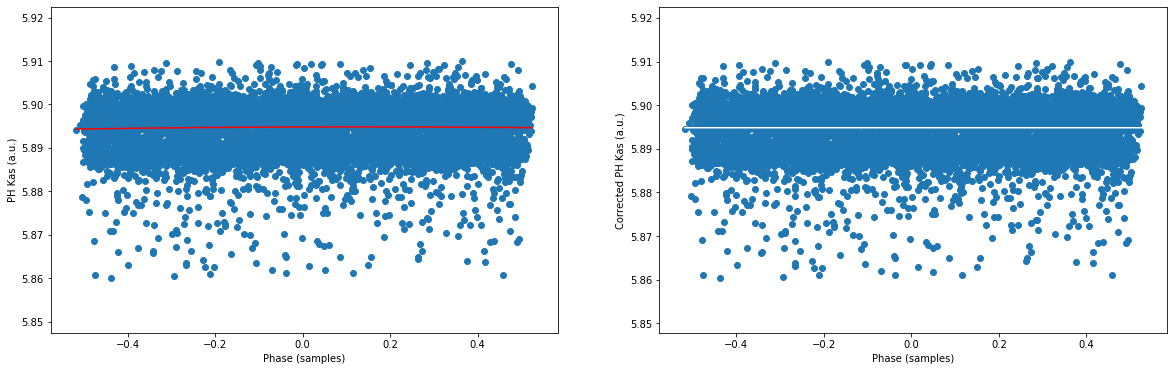

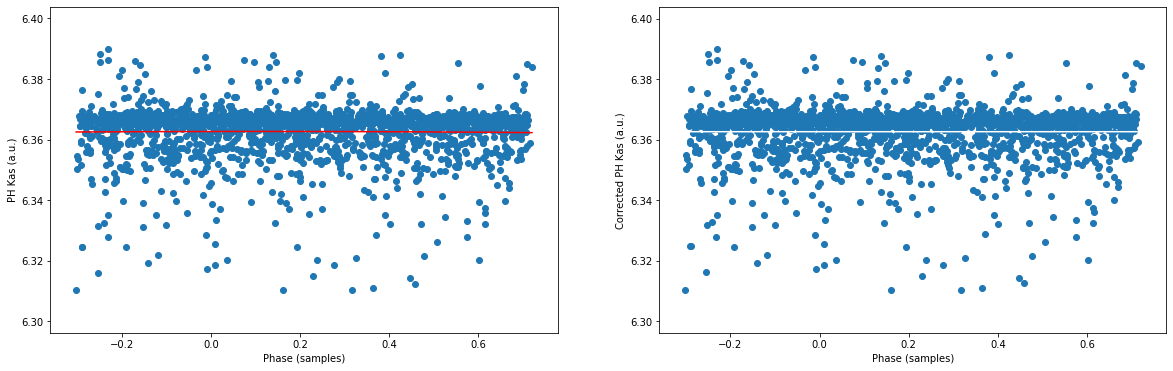

In [30]:
phaseKas_HR = dataKas_HR.PHI + dataKas_HR.LAGS
phaseKb_HR = dataKb_HR.PHI + dataKb_HR.LAGS
#print(len(phaseKas_HR))

dataKas_HR_jitter = jitterCorr(reconPH=dataKas_HR.SIGNAL, phase=phaseKas_HR)
dataKb_HR_jitter = jitterCorr(reconPH=dataKb_HR.SIGNAL, phase=phaseKb_HR)


### 3.2 Fit gaussians, create new Gain scale and re-calibrate energies (OPTIONAL)

In [31]:
%%script false --no-raise-error

# use kernel density function to get an initial (automatic) estimation of the centres of the lines
centresA = getMaximaDensity(data=1e3*dataKas_HR_jitter, nmaxima=2, intervalmin=5875, intervalmax=5900)
print("Estimated initial values for MnKa2 and MnKa1=",centresA)
centresB = getMaximaDensity(data=1e3*dataKb_HR_jitter, nmaxima=1, intervalmin=6350, intervalmax=6380)
print("Estimated initial values for MnKb=",centresB)

(mean1j, mean2j, mean3j) = fit3gauss2hist(data1=1e3*dataKas_HR_jitter, data2=1e3*dataKb_HR_jitter, 
                                          a1=0.056, a2=0.11, a3=0.1, mean1=centresA[0], mean2=centresA[1], mean3=centresB[0],
                                          sig1=5, sig2=5, sig3=5, nbins1=nbinsKas, nbins2=nbinsKb, 
                                          xlab="reconstructed PH", plot=True)

In [32]:
%%script false --no-raise-error

# create gain scale Ka2, Ka1, Kb
recon_lines = (mean1j,mean2j,mean3j)
print("gain scale coefs=", coefs)
coefs = gainScalePolyFit(xData=recon_lines, yData=lines, deg=deg, ylab="MnK Lines energies (eV)")
print("gain scale coefs=", coefs)


In [33]:
%%script false --no-raise-error

# recalibrate energies
enerKas_HR_jitter = np.zeros(len(dataKas_HR_jitter))
enerKb_HR_jitter = np.zeros(len(dataKb_HR_jitter))

for i in range(len(coefs)):
    enerKas_HR_jitter += coefs[i] * (1e3*dataKas_HR_jitter)**(i)
    #enerKas_HR_jitter = inter + slope * 1e3*dataKas_HR_jitter
enerKas_HR_jitter = enerKas_HR_jitter[(enerKas_HR_jitter > min_Ka) & (enerKas_HR_jitter < max_Ka)]

for i in range(len(coefs)):
    enerKb_HR_jitter += coefs[i] * (1e3*dataKb_HR_jitter)**(i)
    #enerKb_HR_jitter = inter + slope * 1e3*dataKb_HR_jitter
enerKb_HR_jitter = enerKb_HR_jitter[(enerKb_HR_jitter>min_Kb) & (enerKb_HR_jitter<max_Kb)]

print(min(enerKas_HR_jitter), max(enerKas_HR_jitter))

### 3.3 Fit histogram of jitter-corrected energies

In [34]:
%%script false --no-raise-error

nbinsKas = 140 
nbinsKb = 150
fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
fitVoigt2hist(data=enerKas_HR_jitter, lines=MnKas, nbins=nbinsKas, ax0=ax1)
fitVoigt2hist(data=enerKb_HR_jitter, lines=MnKb, nbins=nbinsKb, ax0=ax2)

## 4. baseline drift correction

### 4.1 Plot jiterr_recon PH vs Baseline & Fit polynomial


100701.9871794872
Fit Kas= 5.868+ (0.000)*x+(-0.000)*x²
Fit Kas (corrected)= 5.868+ (-0.000)*x+(0.000)*x²
Fit Kb= 6.350+ (0.000)*x+(-0.000)*x²
Fit Kb (corrected)= 6.350+ (-0.000)*x+(0.000)*x²


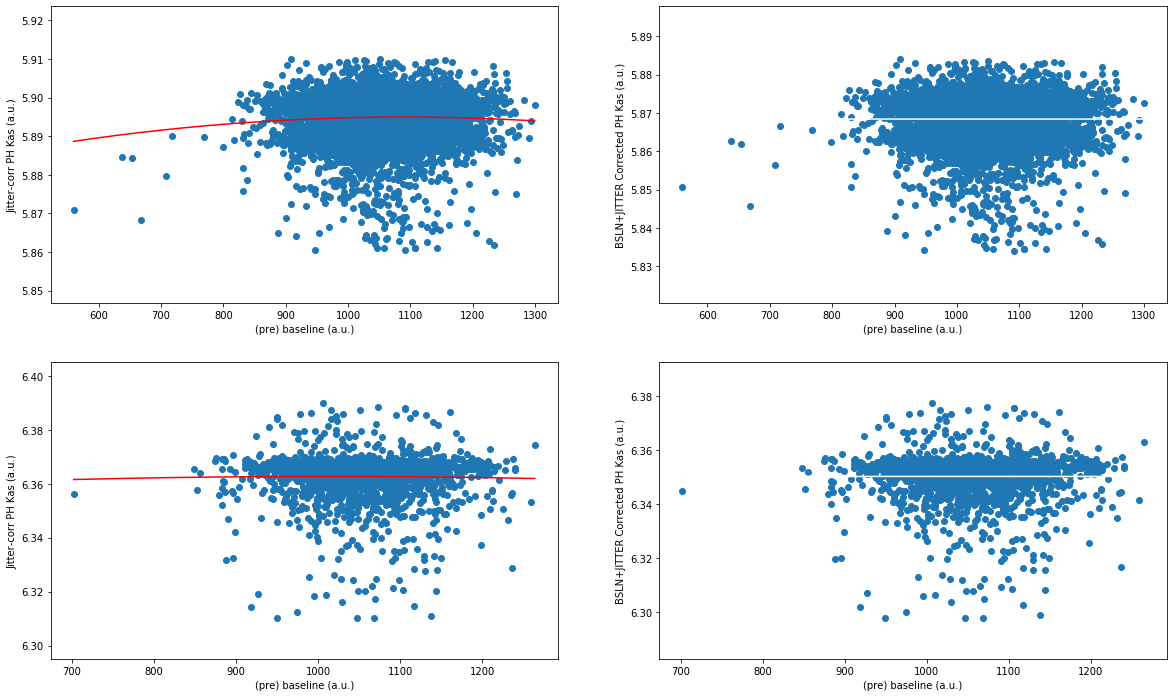

In [35]:
baseKas_HR = dataKas_HR.BSLN - 1e5
baseKb_HR = dataKb_HR.BSLN - 1e5
print(min(dataKb_HR.BSLN))

######## Kas ####################
# plot baselines
fig = plt.figure(figsize=(20,12))

ax1 = fig.add_subplot(2, 2, 1)
ax1.scatter(baseKas_HR, dataKas_HR_jitter, marker="o")
# fit polynomial
x_interval_for_fit = np.linspace(min(baseKas_HR), max(baseKas_HR), 10000)
coefs = poly.polyfit(x=baseKas_HR, y=dataKas_HR_jitter, deg=2) 
#print(coefs)
ffit = poly.polyval(x_interval_for_fit, coefs)
ax1.plot(x_interval_for_fit, ffit,'-', color="red")
ax1.set_xlabel("(pre) baseline (a.u.)")
ax1.set_ylabel("Jitter-corr PH Kas (a.u.)")
print("Fit Kas=",'{:0.3f}'.format(coefs[0]) + "+ (" + '{:0.3f}'.format(coefs[1]) + ")*x" + "+(" + '{:0.3f}'.format(coefs[2]) + ")*x²" )

# subtract polynomial (flat baseline effect)
ax2 = fig.add_subplot(2, 2, 2)
dataKas_HR_jitter_bsln = dataKas_HR_jitter - coefs[1]*baseKas_HR - coefs[2]*baseKas_HR**2
ax2.scatter(baseKas_HR, dataKas_HR_jitter_bsln, marker="o")
ax2.set_xlabel("(pre) baseline (a.u.)")
ax2.set_ylabel("BSLN+JITTER Corrected PH Kas (a.u.)")
coefsB = poly.polyfit(x=baseKas_HR, y=dataKas_HR_jitter_bsln, deg=2)
print("Fit Kas (corrected)=",'{:0.3f}'.format(coefsB[0]) + "+ (" + '{:0.3f}'.format(coefsB[1]) + ")*x" + "+(" + '{:0.3f}'.format(coefsB[2]) + ")*x²" )
ffitB = poly.polyval(x_interval_for_fit, coefsB)
ax2.plot(x_interval_for_fit, ffitB,'-', color="white")

######## Kb ####################
# plot baselines
ax3 = fig.add_subplot(2, 2, 3)
ax3.scatter(baseKb_HR, dataKb_HR_jitter, marker="o")
# fit polynomial
x_interval_for_fit = np.linspace(min(baseKb_HR), max(baseKb_HR), 10000)
coefs = poly.polyfit(x=baseKb_HR, y=dataKb_HR_jitter, deg=2) # recommended instead of np.polyfit + np.poly1d
ffit = poly.polyval(x_interval_for_fit, coefs)
ax3.plot(x_interval_for_fit, ffit,'-', color="red")
ax3.set_xlabel("(pre) baseline (a.u.)")
ax3.set_ylabel("Jitter-corr PH Kas (a.u.)")
print("Fit Kb=",'{:0.3f}'.format(coefs[0]) + "+ (" + '{:0.3f}'.format(coefs[1]) + ")*x" + "+(" + '{:0.3f}'.format(coefs[2]) + ")*x²" )

# subtract polynomial (flat jitter effect)
ax4 = fig.add_subplot(2, 2, 4)
dataKb_HR_jitter_bsln = dataKb_HR_jitter - coefs[1]*baseKb_HR - coefs[2]*baseKb_HR**2
ax4.scatter(baseKb_HR, dataKb_HR_jitter_bsln, marker="o")
ax4.set_xlabel("(pre) baseline (a.u.)")
ax4.set_ylabel("BSLN+JITTER Corrected PH Kas (a.u.)")
coefsB = poly.polyfit(x=baseKb_HR, y=dataKb_HR_jitter_bsln, deg=2)
print("Fit Kb (corrected)=",'{:0.3f}'.format(coefsB[0]) + "+ (" + '{:0.3f}'.format(coefsB[1]) + ")*x" + "+(" + '{:0.3f}'.format(coefsB[2]) + ")*x²" )
ffitB = poly.polyval(x_interval_for_fit, coefsB)
ax4.plot(x_interval_for_fit, ffitB,'-', color="white")

### 4.2 Fit gaussians, create new Gain scale and re-calibrate energies

Estimated initial values for MnKa2 and MnKa1= [5863.26955201 5872.2270913 ]
Estimated initial values for MnKb= [6353.92700152]


<Figure size 432x288 with 0 Axes>

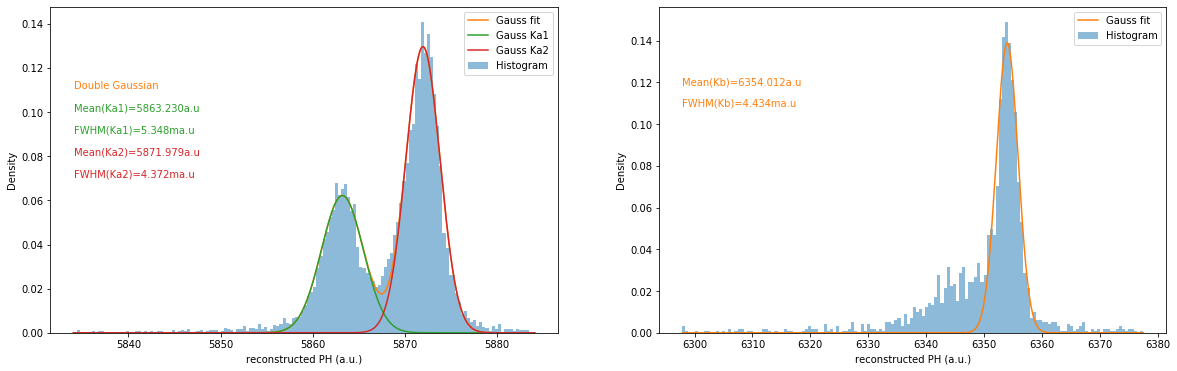

In [36]:
nbinsKas = 150
nbinsKb = 150
# use kernel density function to get an initial (automatic) estimation of the centres of the lines
centresA = getMaximaDensity(data=1e3*dataKas_HR_jitter_bsln, nmaxima=2, intervalmin=5850, intervalmax=5880)
#centresA=[5850,5860] # for oflen=256
print("Estimated initial values for MnKa2 and MnKa1=",centresA)
centresB = getMaximaDensity(data=1e3*dataKb_HR_jitter_bsln, nmaxima=1, intervalmin=6330, intervalmax=6360)
#centresB=[6375]
print("Estimated initial values for MnKb=",centresB)
(mean1bsln, mean2bsln, mean3bsln) = fit3gauss2hist(data1=1e3*dataKas_HR_jitter_bsln, data2=1e3*dataKb_HR_jitter_bsln,
                                          a1=0.06, a2=0.12, a3=0.11, sig1=5, sig2=5, sig3=5,
                                          mean1=centresA[0], mean2=centresA[1], mean3=centresB[0],
                                          nbins1=nbinsKas, nbins2=nbinsKb,
                                          xlab="reconstructed PH (a.u.)", plot=True)

RMSE: 2.4629232953387327e-12
R-squared: 1.0
gain scale coefs= [ 3.49308085e+03 -3.47844845e-01  1.28985173e-04]


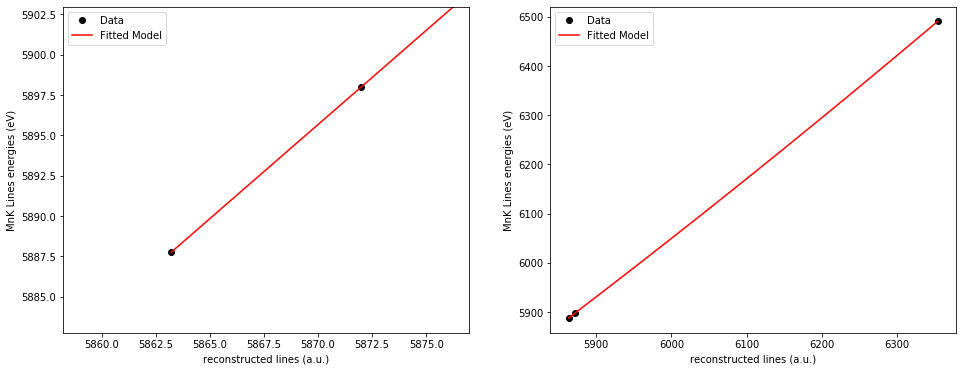

In [37]:
# create gain scale Ka2, Ka1, Kb
recon_lines = (mean1bsln,mean2bsln,mean3bsln)
coefs = gainScalePolyFit(xData=recon_lines, yData=lines, deg=deg, ylab="MnK Lines energies (eV)")
print("gain scale coefs=", coefs)


In [38]:
# recalibrate energies
enerKas_HR_jitter_bsln = np.zeros(len(dataKas_HR_jitter_bsln))
enerKb_HR_jitter_bsln = np.zeros(len(dataKb_HR_jitter_bsln))

for i in range(len(coefs)):
    enerKas_HR_jitter_bsln += coefs[i] * (1e3*dataKas_HR_jitter_bsln)**(i)
    #enerKas_HR_jitter_bsln = inter + slope * 1e3*dataKas_HR_jitter_bsln # eV
enerKas_HR_jitter_bsln = enerKas_HR_jitter_bsln[(enerKas_HR_jitter_bsln > min_Ka) & (enerKas_HR_jitter_bsln < max_Ka)]

for i in range(len(coefs)):
    enerKb_HR_jitter_bsln += coefs[i] * (1e3*dataKb_HR_jitter_bsln)**(i)
    #enerKb_HR_jitter_bsln = inter + slope * 1e3*dataKb_HR_jitter_bsln # eV
enerKb_HR_jitter_bsln = enerKb_HR_jitter_bsln[(enerKb_HR_jitter_bsln>min_Kb) & (enerKb_HR_jitter_bsln<max_Kb)]
print(enerKas_HR_jitter_bsln)
enerKas_HR_jitter_bsln.to_csv("ppHa.csv")
enerKb_HR_jitter_bsln.to_csv("ppHb.csv")



1        5898.711974
2        5900.151152
3        5885.858131
4        5897.069702
7        5900.766961
            ...     
13727    5891.691394
13728    5896.711674
13729    5897.898163
13730    5899.822683
13731    5888.560969
Length: 10910, dtype: float64


## 5 Fit histogram of baseline-jitter-corrected energies

#### Test different number of bins and see how the residuals respond

In [39]:
%%script false --no-raise-error
# Plot residuals curve to select best number of bins for Kas and Kb
plt.clf()
fig = plt.figure(figsize=(20, 6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
fitVoigt2hist(data=enerKas_HR_jitter_bsln, lines=MnKas, nbins=np.arange(50,400,5), ax0=ax1)
ax1.set_title("MnKas")
fitVoigt2hist(data=enerKb_HR_jitter_bsln, lines=MnKb, nbins=np.arange(50,200,1), ax0=ax2)
ax2.set_title("MnKb")

#### Use the range of number of bins where residuals are quite estable and use them to get different FWHM; then take median value

In [40]:
#%%script false --no-raise-error

# Calculate mean 'fit' for range of acceptable number of bins in Kas range
#                                                               ===========
(ibmin, ibmax) = (170, 400)
fwhm_G = list()
err_fwhm_G = list()
nbins = list()
for nbinsKas in np.arange(ibmin, ibmax, 10):
    fw, efw, vv_fit = fitVoigt2hist(data=enerKas_HR_jitter_bsln, lines=MnKas, nbins=int(nbinsKas), ax0=ax1)    
    plt.clf()
    if fw < 0 or efw == 0:
        continue
    fwhm_G.append(fw)
    err_fwhm_G.append(efw)
    nbins.append(nbinsKas)
print("FWHM_Gs=", np.array2string(np.asarray(fwhm_G), formatter={'float_kind':lambda x: "%.3f" % x}))
median_fwhm_G = np.median(fwhm_G)
median_err_fwhm_G = np.sum(abs(np.asarray(fwhm_G)-median_fwhm_G))/len(fwhm_G)
median_index = min(range(len(fwhm_G)), key=lambda i: abs(fwhm_G[i]-median_fwhm_G))
nbinsKas = nbins[median_index]
print("median_index=", median_index)
print("FWHM_G[median_index]=",fwhm_G[median_index])
print("ERR_FWHM_G[median_index]=",err_fwhm_G[median_index])
print("nbinsKas[median_index]=", nbins[median_index])

print("Using ", len(fwhm_G), "different number of bins")
txt_Kas = '{:0.2f}'.format(median_fwhm_G) + "+/-" + '{:0.2f}'.format(max(median_err_fwhm_G, err_fwhm_G[median_index])) + "eV"
print("Median FWHM_G(Kas)=", txt_Kas)


FWHM_Gs= [2.778 2.785 2.787 2.788 2.785 2.772 2.777 2.776 2.786 2.783 2.776 2.778
 2.773 2.783 2.778 2.783 2.786 2.781 2.786 2.775 2.777 2.784 2.783]
median_index= 15
FWHM_G[median_index]= 2.782780521187816
ERR_FWHM_G[median_index]= 0.07114741452203807
nbinsKas[median_index]= 320
Using  23 different number of bins
Median FWHM_G(Kas)= 2.78+/-0.07eV


<Figure size 432x288 with 0 Axes>

In [41]:
#%%script false --no-raise-error

# Calculate mean 'fit' for range of acceptable number of bins in Kb range
#                                                               ===========
(ibmin, ibmax) = (120, 200)
fwhm_G = list()
err_fwhm_G = list()
nbins = list()
for nbinsKb in np.arange(ibmin, ibmax, 2):
    fw, efw, vv_fit = fitVoigt2hist(data=enerKb_HR_jitter_bsln, lines=MnKb, nbins=int(nbinsKb), ax0=ax2)    
    plt.clf()
    if efw == 0 or fw < 0:
        continue
    fwhm_G.append(fw)
    err_fwhm_G.append(efw)
    nbins.append(nbinsKb)
print("FWHM_Gs=", np.array2string(np.asarray(fwhm_G), formatter={'float_kind':lambda x: "%.3f" % x}))
median_fwhm_G = np.median(fwhm_G)
median_err_fwhm_G = np.sum(abs(np.asarray(fwhm_G)-median_fwhm_G))/len(fwhm_G)
median_index = min(range(len(fwhm_G)), key=lambda i: abs(fwhm_G[i]-median_fwhm_G))
nbinsKb = nbins[median_index]
print("median_index=", median_index)
print("FWHM_G[median_index]=",fwhm_G[median_index])
print("ERR_FWHM_G[median_index]=",err_fwhm_G[median_index])
print("nbinsKb[median_index]=", nbins[median_index])

txt_Kb = '{:0.2f}'.format(median_fwhm_G) + "+/-" + '{:0.2f}'.format(max(median_err_fwhm_G, err_fwhm_G[median_index])) + "eV"
print("Median FWHM_G(Kb)=", txt_Kb)


FWHM_Gs= [2.656 2.654 2.621 2.701 2.646 2.759 2.682 2.695 2.698 2.672 2.730 2.621
 2.676 2.708 2.697 2.676 2.689 2.679 2.667 2.753 2.711 2.686 2.672 2.662
 2.637 2.662 2.649 2.693 2.662 2.646 2.707 2.674 2.644 2.714 2.692 2.609
 2.706]
median_index= 15
FWHM_G[median_index]= 2.676374231366112
ERR_FWHM_G[median_index]= 0.11600451954989581
nbinsKb[median_index]= 152
Median FWHM_G(Kb)= 2.68+/-0.12eV


<Figure size 432x288 with 0 Axes>

Using nbinsKas= 320 and nbinsKb= 152 from median estimation
2.782780521187816 0.07114741452203807
2.676374231366112 0.11600451954989581


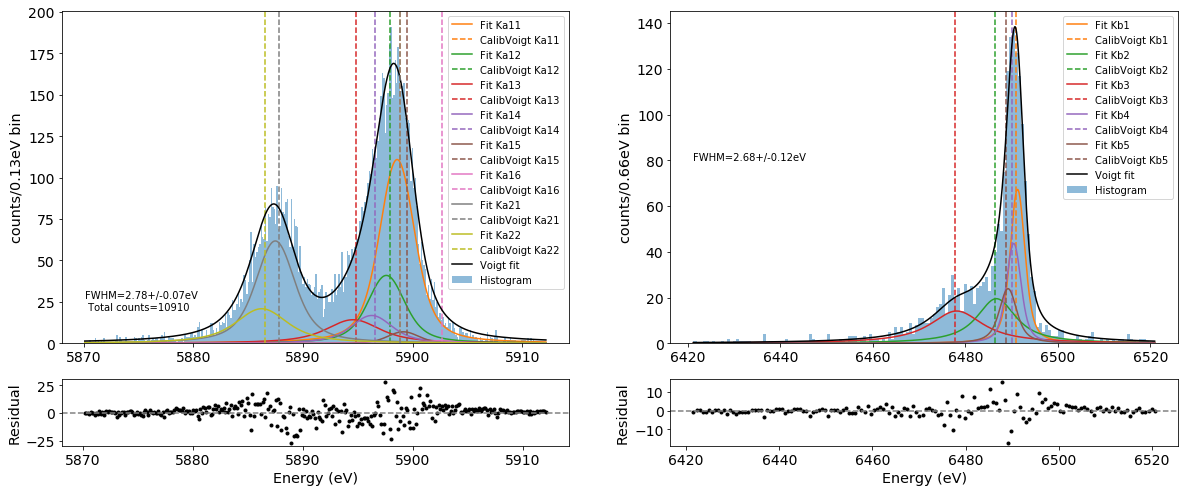

In [53]:
#%%script false --no-raise-error

# Plot representative (median) fitting 
fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
print("Using nbinsKas=", nbinsKas, "and nbinsKb=", nbinsKb, "from median estimation")

nlines_Kas = MnKas.getNumber() 
nlines_Kb = MnKb.getNumber()
nlines = nlines_Kas + nlines_Kb 
lines_centres_vv = np.zeros(nlines)

fwhm_G, err_fwhm_G, vvmod = fitVoigt2hist(data=enerKas_HR_jitter_bsln, lines=MnKas, nbins=int(nbinsKas), ax0=ax1)
print(fwhm_G, err_fwhm_G)
for i in range(nlines_Kas):
     lines_centres_vv[i] = vvmod.param_sets[i*4][0]

#nbinsKb=100
fwhm_G, err_fwhm_G, vvmod = fitVoigt2hist(data=enerKb_HR_jitter_bsln, lines=MnKb, nbins=int(nbinsKb), ax0=ax2)
print(fwhm_G, err_fwhm_G)
for i in range(nlines_Kb):
    j = i + nlines_Kas
    lines_centres_vv[j] = vvmod.param_sets[i*4][0]

x1 = min(enerKas_HR_jitter_bsln)
y1 = 20
ax1.text(x1,y1, "FWHM=" + txt_Kas + "\n Total counts=" + str(len(enerKas_HR_jitter_bsln)))
ax1.axvline(MnKas.energies_eV[0], ls="--", color="gray")

x2 = min(enerKb_HR_jitter_bsln)
y2 = 80
ax2.text(x2,y2, "FWHM=" + txt_Kb)

outfig=resDir + "/fit_" + "pL" + str(plen) + "_" + method + str(oflen) + pBstr + "_jitter_bsln.png"
fig.savefig(outfig)

In [ ]:
%%script false --no-raise-error
# Plot representative fitting for a fixed size bin (only for Kas)
fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(1,2,1)

nbinsKas = 250
fwhm_G, err_fwhm_G, vvmod = fitVoigt2hist(data=enerKas_HR_jitter_bsln, lines=MnKas, nbins=int(nbinsKas), ax0=ax1)
print(fwhm_G, err_fwhm_G)

txt_Kas = '{:0.2f}'.format(fwhm_G) + "+/-" + '{:0.2f}'.format(err_fwhm_G) + "eV"
x1 = min(enerKas_HR_jitter_bsln)
y1 = 10
ax1.text(x1,y1, "FWHM=" + txt_Kas + "\n Total counts=" + str(len(enerKas_HR_jitter_bsln)))
ax1.axvline(MnKas.energies_eV[0], ls="--", color="gray")


outfig=resDir + "/fitKas_" + "pL" + str(plen) + "_" + method + str(oflen) + pBstr + "_jitter_bsln_300bins.png"
#fig.savefig(outfig)

## 6. Plot FWHM values for different methods and reconstruction lenths

In [ ]:
%%script false --no-raise-error
# plot variation of FWHM for different record lengths and for OPTFILT and preBuffer

rlen = (256, 512, 1024, 2048, 4096, 8192)
# 300 bins fit
optf =     (7.12, 3.03, 2.80, 2.74, 2.85, 2.85)
optf_err = (0.14, 0.07, 0.08, 0.06, 0.07, 0.07)
pB =       (9.19, 2.86, 2.64, 2.57, 2.72, 2.78)
pB_err =   (0.18, 0.07, 0.07, 0.07, 0.07, 0.08)

fig = plt.figure(figsize=(12,9))
ax1 = fig.add_subplot(1, 1, 1)
ax1.errorbar(rlen, optf, yerr=optf_err, label="ADC OPTFILT", marker='o',capsize=3, ls="-", alpha=0.5)
ax1.errorbar(rlen, pB, yerr=pB_err, label="ADC preBuffer75 OPTFILT", marker='o',capsize=2, ls="-")
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_ylim(2.5,10)
ax1.set_xlabel("record length (samples)",fontsize='x-large')
ax1.set_ylabel("FWHM (eV)", fontsize='x-large')
ax1.legend()
#ax1.grid()

axins = inset_axes(ax1, width="70%", height=1.9, bbox_transform=ax1.transAxes, bbox_to_anchor=(0.4, 0.3, 0.5, 0.9), loc=4)
axins.errorbar(rlen, optf, yerr=optf_err, label="ADC OPTFILT", marker='o',capsize=3, ls="-", alpha=0.5)
axins.errorbar(rlen, pB, yerr=pB_err, label="ADC preBuffer75 OPTFILT", marker='o',capsize=2, ls="-")
axins.set_ylim(2.5,4)
axins.grid()
axins.set_xlabel("record length (samples)",fontsize='large')
axins.set_ylabel("FWHM (eV)", fontsize='large')

outfig=resDir + "/fitKas_comparative_jitter_bsln_300bins.png"
fig.savefig(outfig)


## 7. Recalibrate energies:
      - get new gain scale with fitted line centres
      - recalibrate energies
      - fit again to get FWHM more precisely

In [57]:
# reverse au to energy transformation of lines centres using gain scale
#lines_centres_Kas 
#lines_centres_Kb 
# Ecal = coefs[0] + coefs[1] * PHau + coefs[2] * PHau^2 + ....
# to get roots:    0 = coefs[0]-Ecal + coefs[1] * PHau + coefs[2] * PHau^2 + ....
PHau = np.zeros(nlines)
newcoefs = np.zeros(len(coefs))
np.copyto(newcoefs, coefs)

for i in range(nlines):  
    line = lines_centres_vv[i]
    coef0 = coefs[0] - line
    newcoefs[0] = coef0
    calpoly = P(newcoefs)
    PHau[i] = max(calpoly.roots())
    #print("PH for ", line, "=", PHau[i])

PH for  5898.576698862527 = 5872.499110169603
PH for  5897.5927497901985 = 5871.655949553589
PH for  5894.558906817182 = 5869.055214347252
PH for  5896.260818728874 = 5870.514347549692
PH for  5899.138669775789 = 5872.980600919327
PH for  5902.406500637956 = 5875.779429299964
PH for  5887.4672738690515 = 5862.970130237971
PH for  5886.223338253221 = 5861.9019065331195
PH for  6491.282645242241 = 6354.657262906949
PH for  6486.702368190064 = 6351.109440151335
PH for  6478.121849170918 = 6344.4563014894575
PH for  6490.452595034096 = 6354.014503419792
PH for  6489.222520629253 = 6353.06182851184
